In [ ]:
import networkx as nx
import pandas as pd
from networkx.algorithms.community.quality import modularity
import matplotlib.pyplot as plt
import random

In [ ]:
#import the Karate Club Dataset
G = nx.karate_club_graph()

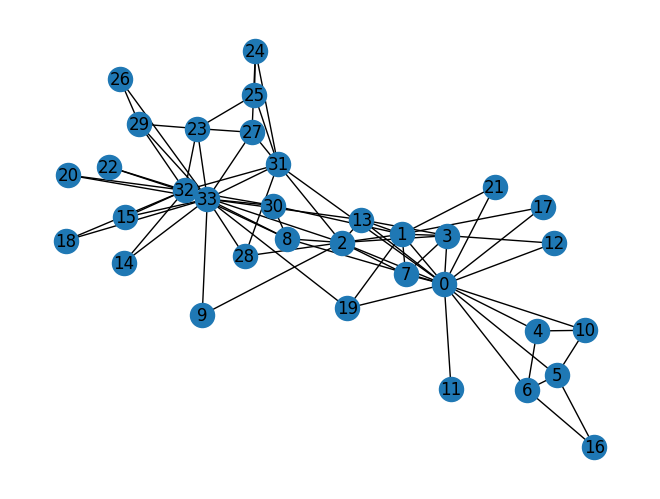

In [ ]:
#Visualizing the graph
nx.draw(G, with_labels = True)

In [ ]:
print ("Density: ",nx.density(G))
print ("Is Connected? ", nx.is_connected(G))
print ("Number of connected components: ",nx.number_connected_components(G))
print ("Diameter: ", nx.diameter(G))
print ("Average Shortest Path Length: ", nx.average_shortest_path_length(G))

Density:  0.13903743315508021
Is Connected?  True
Number of connected components:  1
Diameter:  5
Average Shortest Path Length:  2.408199643493761


In [ ]:
#Calculating clustering coefficients and storing to a DataFrame
clustering_coefficient = pd.DataFrame.from_dict(dict(nx.clustering(G)), orient='index', columns=['clustering_coefficient'])
clustering_coefficient

,clustering_coefficient
0,0.150000
1,0.333333
2,0.244444
3,0.666667
4,0.666667
5,0.500000
6,0.500000
7,1.000000
8,0.500000
9,0.000000


In [ ]:
#calculating Betweenness Centrality
betweenness = pd.DataFrame.from_dict(nx.betweenness_centrality(G), orient='index', columns=['Betweenness_Centrality'])
betweenness

,Betweenness_Centrality
0,0.437635
1,0.053937
2,0.143657
3,0.011909
4,0.000631
5,0.029987
6,0.029987
7,0.000000
8,0.055927
9,0.000848


In [ ]:
#Calculating the degree
degree = pd.DataFrame.from_dict(dict(G.degree()), orient='index', columns=['degree'])
degree

,degree
0,16
1,9
2,10
3,6
4,3
5,4
6,4
7,4
8,5
9,2


In [ ]:
#Calculating the vulnerability using clustering coefficient, betweeness, degree
vulnerability = pd.concat([clustering_coefficient, betweenness, degree], axis=1)

vulnerability['Vulnerability'] = (
    (vulnerability['clustering_coefficient'] / vulnerability['degree']) + (vulnerability['Betweenness_Centrality'] * vulnerability['degree']))
vulnerability.sort_values(by='Vulnerability', ascending=False).head(5)

,clustering_coefficient,Betweenness_Centrality,degree,Vulnerability
0,0.150000,0.437635,16,7.011540
33,0.110294,0.304075,17,5.175762
32,0.196970,0.145247,12,1.759380
2,0.244444,0.143657,10,1.461013
31,0.200000,0.138276,6,0.862987


In [ ]:
#Finding out all Highly Vulnerable Nodes
high_vuln_nodes = vulnerability[vulnerability['Vulnerability'] > 1].index.tolist()

In [ ]:
#Finding all Cut-Vertices
cut_vertices = list(nx.articulation_points(G))
print("Cut vertices:", cut_vertices[:20])

Cut vertices: [0]


In [ ]:
#Finding the Influencer Nodes
influencers = set(high_vuln_nodes).union(set(cut_vertices))
influencers

{0, 2, 32, 33}

In [ ]:
#Initialize each influencer as its own community.
def initialize_communities(G, influencers):
    communities = {i: set([i]) for i in influencers}
    node_to_comm = {i: i for i in influencers}
    return communities, node_to_comm

In [ ]:
#assigning unassigned nodes to community
def assign_unassigned_nodes(G, influencers, communities, node_to_comm):
    unassigned = [n for n in G.nodes if n not in node_to_comm]
    changed = True

    while unassigned and changed:
        changed = False
        for node in unassigned.copy():
            # Count connections to each community
            neighbor_comms = {}
            for nbr in G.neighbors(node):
                if nbr in node_to_comm:
                    comm_id = node_to_comm[nbr]
                    neighbor_comms[comm_id] = neighbor_comms.get(comm_id, 0) + 1

            if neighbor_comms:
                # Assign to community with strongest connection
                best_comm = max(neighbor_comms, key=neighbor_comms.get)
                communities[best_comm].add(node)
                node_to_comm[node] = best_comm
                unassigned.remove(node)
                changed = True

        if not changed:
            break

    # Handle any remaining unassigned nodes
    for node in unassigned:
        # Assign randomly or to nearest influencer
        best_comm = random.choice(list(influencers))
        communities[best_comm].add(node)
        node_to_comm[node] = best_comm

    return communities, node_to_comm

In [ ]:
def modularity_refinement(G, communities, node_to_comm, influencers, max_iter=10):

    for _ in range(max_iter):
        moved = False
        for node in G.nodes:

            if node in influencers:
                continue

            current_comm = node_to_comm[node]

            # Calculate current modularity
            partition = [list(c) for c in communities.values()]
            current_modularity = modularity(G, partition)

            best_comm = current_comm
            best_modularity = current_modularity

            # Try moving node to other communities
            for comm_id in communities:
                if comm_id == current_comm:
                    continue

                # Temporarily move node
                communities[current_comm].remove(node)
                communities[comm_id].add(node)
                node_to_comm[node] = comm_id

                new_partition = [list(c) for c in communities.values()]
                new_modularity = modularity(G, new_partition)

                # Keep the move if modularity improves
                if new_modularity > best_modularity:
                    best_modularity = new_modularity
                    best_comm = comm_id
                    moved = True

                # Revert move
                communities[comm_id].remove(node)
                communities[current_comm].add(node)
                node_to_comm[node] = current_comm

            # If best community is not current, finalize the move
            if best_comm != current_comm:
                communities[current_comm].remove(node)
                communities[best_comm].add(node)
                node_to_comm[node] = best_comm

        if not moved:
            break

    return communities, node_to_comm


In [ ]:
def influencer_kmeans_modularity(G, influencers, max_iter=10):
    communities, node_to_comm = initialize_communities(G, influencers)
    communities, node_to_comm = assign_unassigned_nodes(G, influencers, communities, node_to_comm)
    communities, node_to_comm = modularity_refinement(G, communities, node_to_comm,influencers, max_iter=max_iter)

    final_modularity = modularity(G, [list(c) for c in communities.values()])
    return communities, node_to_comm, final_modularity

In [ ]:
communities, node_to_comm, Q = influencer_kmeans_modularity(G, influencers)
print("Final communities:", communities)
print("Modularity Score:", Q)


Final communities: {0: {0, 1, 3, 4, 5, 6, 7, 12, 10, 11, 13, 16, 17, 19, 21}, 33: {33, 9, 15, 18, 22}, 2: {2, 8, 28, 30}, 32: {14, 24, 25, 26, 27, 20, 23, 32, 29, 31}}
Modularity Score: 0.34095125653567215


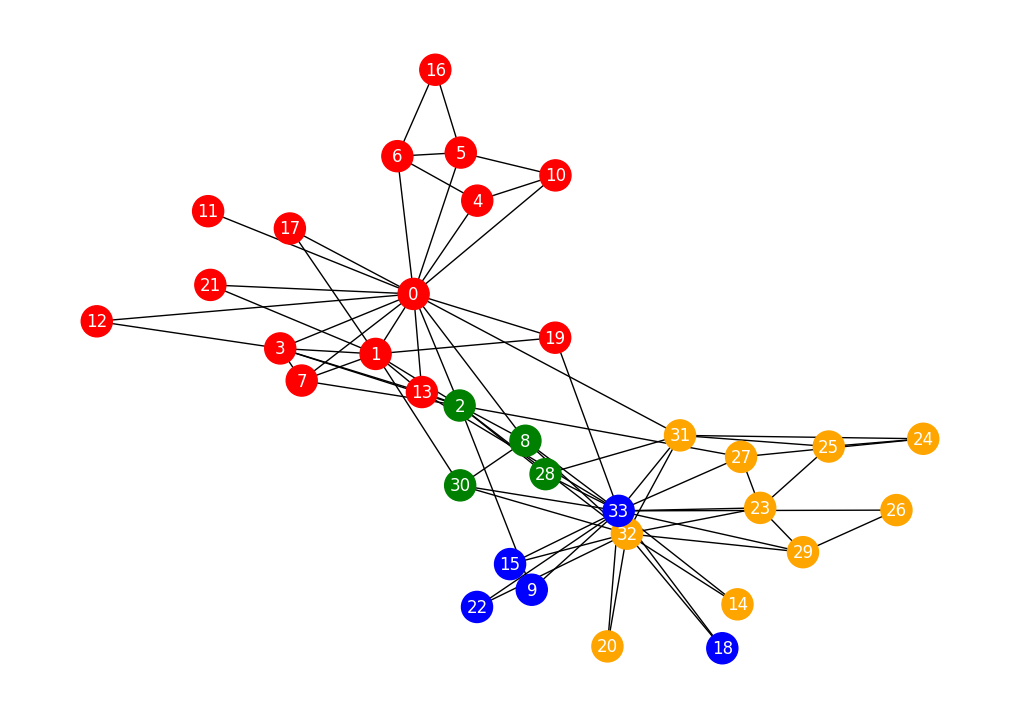

In [ ]:
color_list = ['red', 'blue', 'green', 'orange']
node_colors = []

for node in G.nodes():
    for idx, comm_id in enumerate(communities):
        if node in communities[comm_id]:
            node_colors.append(color_list[idx])
            break

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_color='white')
plt.show()